# Model Training

In [39]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
import warnings

In [40]:
dataset=pd.read_csv('data/loan_approval_dataset.csv')
dataset.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [41]:
q1=dataset[' residential_assets_value'].quantile(0.25)
q2=dataset[' residential_assets_value'].quantile(0.75)
q1_c=dataset[' commercial_assets_value'].quantile(0.25)
q2_c=dataset[' commercial_assets_value'].quantile(0.75)
IQR=q2-q1
IQR_c=q2_c-q1_c

In [42]:
max_val=q2+1.5*IQR
max_val_c=q2_c+1.5*IQR_c
dataset=dataset[dataset[' residential_assets_value']<max_val]
dataset=dataset[dataset[' commercial_assets_value']<max_val_c]
dataset.shape

(4182, 13)

In [43]:
X=dataset.drop(columns=[' loan_status'])
y=dataset[' loan_status']

In [44]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)
num_features

Index(['loan_id', ' no_of_dependents', ' income_annum', ' loan_amount',
       ' loan_term', ' cibil_score', ' residential_assets_value',
       ' commercial_assets_value', ' luxury_assets_value',
       ' bank_asset_value'],
      dtype='object')

In [45]:
X = preprocessor.fit_transform(X)
X

array([[ 0.        ,  1.        ,  0.        , ..., -0.62309647,
        -0.67556925, -0.49580784],
       [ 1.        ,  0.        ,  1.        , ..., -0.07614132,
         2.04561226,  2.47778177],
       [ 1.        ,  0.        ,  1.        , ..., -0.36150922,
         0.93492593,  0.94403555],
       ...,
       [ 0.        ,  1.        ,  1.        , ...,  1.80253069,
         0.35736904,  0.75622989],
       [ 0.        ,  1.        ,  1.        , ..., -0.97980634,
        -0.0869055 ,  0.28671574],
       [ 1.        ,  0.        ,  1.        , ...,  1.65984674,
         2.31217698,  2.22737422]], shape=(4182, 14))

# Separate dataset into train and test

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((3345, 14), (837, 14))

### Create an Evaluate Function to give all metrics after model Training


In [47]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import numpy as np

def evaluate_classifier_simple(y_true, y_pred, y_pred_proba):
    """
    Calculates key evaluation metrics for a classification model.
    
    Args:
        y_true (array-like): Ground truth (correct) labels.
        y_pred (array-like): Predicted labels.
        y_pred_proba (array-like): Predicted probabilities.

    Returns:
        tuple: A tuple containing accuracy, F1-score, and ROC AUC score.
    """
    # 1. Accuracy: Overall proportion of correct predictions.
    accuracy = accuracy_score(y_true, y_pred)
    
    # 2. F1-Score: Harmonic mean of precision and recall.
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    # 3. ROC AUC Score: Handle both binary and multi-class cases
    n_classes = y_pred_proba.shape[1] if hasattr(y_pred_proba, 'shape') and len(y_pred_proba.shape) > 1 else 2
    
    if n_classes == 2:
        # Binary classification: use probabilities for positive class
        if y_pred_proba.ndim > 1 and y_pred_proba.shape[1] == 2:
            roc_auc = roc_auc_score(y_true, y_pred_proba[:, 1])
        else:
            roc_auc = roc_auc_score(y_true, y_pred_proba)
    else:
        # Multi-class classification: use one-vs-rest approach
        # Convert true labels to one-hot encoding for multi-class ROC AUC
        lb = LabelBinarizer()
        y_true_binarized = lb.fit_transform(y_true)
        roc_auc = roc_auc_score(y_true_binarized, y_pred_proba, multi_class='ovr')
    
    return accuracy, f1, roc_auc

models = {
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "Support Vector Classifier": SVC(probability=True),
    'AdaBoostClassifier': AdaBoostClassifier()
}

model_list = []
accuracy_list = []
f1_list = []
roc_auc_list = []

for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Get predicted probabilities
    y_train_proba = model.predict_proba(X_train)
    y_test_proba = model.predict_proba(X_test)

    # Evaluate Train and Test dataset
    model_train_accuracy, model_train_f1, model_train_roc_auc = evaluate_classifier_simple(
        y_train, y_train_pred, y_train_proba
    )
    
    model_test_accuracy, model_test_f1, model_test_roc_auc = evaluate_classifier_simple(
        y_test, y_test_pred, y_test_proba
    )

    print(name)
    model_list.append(name)
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print("- F1 Score: {:.4f}".format(model_train_f1))
    print("- ROC AUC: {:.4f}".format(model_train_roc_auc))
    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Accuracy: {:.4f}".format(model_test_accuracy))
    print("- F1 Score: {:.4f}".format(model_test_f1))
    print("- ROC AUC: {:.4f}".format(model_test_roc_auc))
    print('=' * 35)
    print('\n')
    
    # Store results for comparison
    accuracy_list.append(model_test_accuracy)
    f1_list.append(model_test_f1)
    roc_auc_list.append(model_test_roc_auc)

# Optional: Create a results dataframe for easy comparison
import pandas as pd
results_df = pd.DataFrame({
    'Model': model_list,
    'Test Accuracy': accuracy_list,
    'Test F1 Score': f1_list,
    'Test ROC AUC': roc_auc_list
}).sort_values('Test ROC AUC', ascending=False)

print("Model Performance Comparison:")
print(results_df)

Logistic Regression
Model performance for Training set
- Accuracy: 0.9229
- F1 Score: 0.9176
- ROC AUC: 0.9714
----------------------------------
Model performance for Test set
- Accuracy: 0.9188
- F1 Score: 0.9150
- ROC AUC: 0.9586


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.9306
- F1 Score: 0.9260
- ROC AUC: 0.9811
----------------------------------
Model performance for Test set
- Accuracy: 0.8817
- F1 Score: 0.8768
- ROC AUC: 0.9495


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 Score: 1.0000
- ROC AUC: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9677
- F1 Score: 0.9661
- ROC AUC: 0.9659


Random Forest Classifier
Model performance for Training set
- Accuracy: 1.0000
- F1 Score: 1.0000
- ROC AUC: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9809
- F1 Score: 0.9799
- ROC AUC: 0.9963


Support Vector Classifier
Model performance for Training s

In [48]:
y_pred_train = models['Decision Tree'].predict(X_train)

### Decission Tree Performs the best

In [49]:
dt_model = DecisionTreeClassifier()
dt_model = dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
score = accuracy_score(y_test, y_pred)*100
train_score = accuracy_score(y_train, y_pred_train)*100
print(" Accuracy of the model is %.2f" %score)
print(" Accuracy of the Training data is %.2f" %train_score)


 Accuracy of the model is 96.77
 Accuracy of the Training data is 100.00


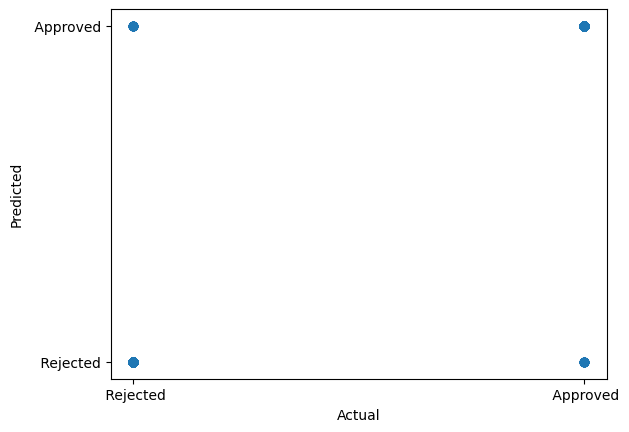

In [50]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');